# Classification of Real and Fake Jobpostings Using Ensemble Model

Classification of dataset with imbalanced classes and the treatment of missing values are two of the tricky issues of machine learning. In this notebook on a dataset of real and fake job postings, I am trying to tackle these two problems with an ensemble model, by training three different machine learning models with different segments of samples, and taking a simple majority vote of three models as the final predictions. Apparently the three models complement each other and achieve decent results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# The Dataset

To make good decisions about data analysis and modeling, we have to understand the data first. The dataset, named The Employment Scam Aegean Dataset (EMSCAD) by researchers of University of the Aegean, consists of 17,800 job ads posted between 2012 to 2014 through Workable, a recruiting software, whose 866 fraudulent job ads were manually annotated by employees of Workable. The criteria of inclusion is said to be including "client’s suspicious activity on the system, false contact or company information, candidate complaints and periodic meticulous analysis of the clientele". So on one hand there may be a small number of mislabeled job ads, on the other hand the annotation may include factors not contained in the dataset.

And the dataset includes structured and unstructured data, open text fields include "title", "company profile", "description", "requirements", "benefits", and to some extent 'location", "department" and "salary range". Structured fields include "employment type", "required experience", "required education", "industry" and "function", and there are binary fields indicating whether the ad has "company logo" and screening "questions", and whether the job involves "telecommuting". The following table lists the details of the feature fields of the dataset:




**String Data**                                              
1. **Title**: The job advertisement header
1. **Location**: The location of the job adviser
1. **Department**: Job relevant department like sales
1. **Salary range**: Suggested Salary Range such as $50,000 - 60,000

**HTML Fragment**
1. **Company Profile**: A brief description of the company
1. **Description**: Advertised Job details
1. **Requirement**: Required list for job
1. **Benefits**: Benefits list offered by employer

**Binary**
1. **Telecommuting**: True for Telecommuting positions
1. **Company Logo**: True if company logo exists
1. **Questions**: True if screening question exists
1. **Fraudulent**: Classification attribute

**Nominal**
1. **Employment Type**: Full-type, Part-time, Contract, etc.
1. **Required Experience**: Executive, Entry level, Intern, etc.
1. **Required Education**: Doctorate, Master’s Degree, Bachelor’s, etc.
1. **Industry**: Automotive, IT, Health care, Real estate, etc.
1. **Function**: Consulting, Engineering, Research, Sales etc.


In [2]:
df=pd.read_csv('fake_job_postings.csv', index_col='job_id')
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.shape

(17880, 17)

In [4]:
df.dtypes

title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Before we go into data exploration, perhaps we should decide on whether we should **drop duplicated** records in dataset first. This is a contentious issue among data scientists. One view is that duplicated records could result in bias in trained models, the other view is they reflect the distribution of the population of observations, and should be left as they are. In the EMSCAD dataset there are a small portion of identical records, supposed to be job ads reposted. But among genuine and fraudulent job ads, the rates of duplication are more or the same, so apparently they can be safely dropped.

In [5]:
df.duplicated().value_counts()

False    17599
True       281
dtype: int64

In [6]:
df[df.fraudulent==0].duplicated().value_counts(normalize=True)

False    0.984072
True     0.015928
dtype: float64

In [7]:
df[df.fraudulent==1].duplicated().value_counts(normalize=True)

False    0.988453
True     0.011547
dtype: float64

In [8]:
df.drop_duplicates(inplace=True)

At the first look of the dataset with duplicates dropped, two things stand out. The first is **highly imbalance of data**, with the fraudulent class of job ads totaling less than 5% of all the records. So we may set the baseline of accuracy of the trained model at 95%, as this score can be achieved by simply labelling all ads as genuine. 

The second thing is the **wide spread of missing values**, with some features the missing value rates exceeding 80%.

In [9]:
df.fraudulent.value_counts()

0    16743
1      856
Name: fraudulent, dtype: int64

In [10]:
df.fraudulent.value_counts(normalize=True)

0    0.951361
1    0.048639
Name: fraudulent, dtype: float64

In [11]:
df.describe(include='all')

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,17599,17258,6271,2827,14317,17598,14951,10493,17599.000000,17599.000000,17599.000000,14171,10637,9590,12762,11236,17599.000000
unique,11231,3105,1337,874,1709,14801,11968,6205,NaN,NaN,NaN,5,7,13,131,37,NaN
top,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,NaN,NaN,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,NaN
freq,309,718,541,141,723,376,407,723,NaN,NaN,NaN,11423,3768,5099,1711,1730,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042843,0.794136,0.492017,NaN,NaN,NaN,NaN,NaN,0.048639
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202510,0.404343,0.499950,NaN,NaN,NaN,NaN,NaN,0.215119
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [12]:
df.isna().sum()

title                      0
location                 341
department             11328
salary_range           14772
company_profile         3282
description                1
requirements            2648
benefits                7106
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3428
required_experience     6962
required_education      8009
industry                4837
function                6363
fraudulent                 0
dtype: int64

# Data Exploration: First look

For data exploration, I provisionally fill the null values with 'na', then separate the real and fake job ads to look into differences between them.

In [13]:
df_na=df.fillna('na') 

In [14]:
real=df_na[df_na.fraudulent==0]
real.describe(include='all')

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,16743,16743,16743,16743,16743,16743,16743,16743,16743.000000,16743.000000,16743.000000,16743,16743,16743,16743,16743,16743.0
unique,10730,2914,1270,829,1661,14171,11495,5904,NaN,NaN,NaN,6,8,14,131,38,NaN
top,English Teacher Abroad,"GB, LND, London",na,na,na,"Play with kids, get paid for it Love travel? J...",na,na,NaN,NaN,NaN,Full-time,na,na,na,na,NaN
freq,309,716,10804,14137,2702,376,2497,6748,NaN,NaN,NaN,10936,6535,7565,4567,6033,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041211,0.817894,0.502299,NaN,NaN,NaN,NaN,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198784,0.385943,0.500010,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.0


In [15]:
fake=df_na[df_na.fraudulent==1]
fake.describe(include='all')

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,856,856,856,856,856,856,856,856,856.000000,856.000000,856.000000,856,856,856,856,856,856.0
unique,560,374,104,118,50,632,479,308,NaN,NaN,NaN,6,8,11,63,28,NaN
top,Cruise Staff Wanted *URGENT*,"US, TX, Houston",na,na,na,We are a full-service marketing and staffing f...,na,na,NaN,NaN,NaN,Full-time,na,na,na,na,NaN
freq,20,91,524,635,580,22,151,359,NaN,NaN,NaN,487,427,444,270,330,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.074766,0.329439,0.290888,NaN,NaN,NaN,NaN,NaN,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263168,0.470284,0.454437,NaN,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.0


Though the duplicated records are dropped, the dataset still has a lot of very similar records, such as among the real ads, there are 309 pieces titled "English Teacher Abroad", and there are 20 fake ads titled "Cruise Staff Wanted URGENT". But these ads are not identical in all fields, so they are reserved.

Then let's have a look at the fake ads.

In [16]:
fake.sample(10)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
4053,Administrative Assitstant,"US, NY, New York",Administrative,21-63000,na,"Experienced, reliable team members are needed ...",6 months to a year experience working in a fas...,"Health, Dental, Life and AD&amp;D Insurance, E...",0,0,0,Full-time,Entry level,Bachelor's Degree,Telecommunications,Administrative,1
17679,Vacancy in Halliburton,"GB, ABE, Scotland",na,80000-120000,na,The Human Resource Department of Halliburton O...,Interested persons should possess a minimum o...,na,0,0,1,Full-time,Entry level,Certification,Oil & Energy,na,1
17535,Photoshop master,"US, NY, NY",na,na,na,We need a Photoshop master - AE adventage...,PhotoshopAE,"12,000$",0,0,1,Full-time,Entry level,Some College Coursework Completed,Design,Design,1
8586,ER Trauma RN,"US, NV,",na,na,na,Find more jos at #URL_1efb08d6a6da1c56afb2d0c6...,na,na,0,0,0,Full-time,na,na,Hospital & Health Care,na,1
15582,Test Automation Engineer,"US, OH, Groveport",na,na,na,Position: Test Automation EngineerLocation: G...,Requirements:Experience with WebService techno...,na,0,0,0,Contract,na,na,Information Technology and Services,Information Technology,1
17585,CASH Pay Jobs (Part Time Staff Wanted),"AU, NSW, Sydney",na,na,na,CASH Pay Jobs (Part Time Staff Wanted)You can ...,No any experience required.,na,0,0,0,Part-time,na,na,na,na,1
6519,WAREHOUSE ASSOCIATE,"US, TX, Austin",WWAREHOUSE ASSOCIATE,23000-26000,The Accion story began more than 100 years ag...,Shipping ResponsibilitiesThe shipping function...,"MUST BE ABLE TO PASS A BACKGROUND CHECK , DRUG...",ALL FULL- TIME BENEFITS,0,1,1,Full-time,Entry level,High School or equivalent,Warehousing,Distribution,1
17802,Administrative Position,"AU, QLD,",na,40000-45000,na,International private equity looking for an ad...,The ideal candidate should have a college degr...,na,1,0,0,Contract,Entry level,High School or equivalent,Consumer Services,Administrative,1
11763,Client Service Manager,"US, NY, NY",na,na,Aptitude Staffing Solutions has redesigned the...,#URL_b0c46563ede9cd7db1c4789a59b5459bbd3bc82e0...,REQUIREMENTSBasic Qualifications:Proven experi...,Our core values drive our culture. This is wha...,0,1,0,Full-time,Mid-Senior level,na,Information Technology and Services,na,1


In [17]:
fake.loc[17512,:]

title                          Use Your Spare Time to Start Earning More
location                                           US, CA, San Francisco
department                                                            na
salary_range                                                          na
company_profile                                                       na
description            Several people around the world have discovere...
requirements           Professional mannerPositive outlookAbility to ...
benefits               If you have a laptop, phone and a strong desir...
telecommuting                                                          0
has_company_logo                                                       0
has_questions                                                          1
employment_type                                                       na
required_experience                                                   na
required_education                                 

In [18]:
fake.loc[3609, :]

title                             Account Sales Managers $80-$130,000/yr
location                                                   US, NY, Utica
department                                                            na
salary_range                                                          na
company_profile        We have aggressive growth plans in place for t...
description            We provide No Credit Check Financing to custom...
requirements           Experience and Skills  Required- Minimum of 3 ...
benefits               We Provide- Complete online training and offic...
telecommuting                                                          0
has_company_logo                                                       1
has_questions                                                          0
employment_type                                                Full-time
required_experience                                            Associate
required_education                             High

In [19]:
fake.loc[7655, :]

title                                        Admin Clerk Remote Position
location                                                US, SC, Columbia
department                                                            na
salary_range                                                          na
company_profile                                                       na
description            We are seeking individuals to be connected wit...
requirements           Home Office SuppliesComputer with internet acc...
benefits                                                              na
telecommuting                                                          1
has_company_logo                                                       0
has_questions                                                          0
employment_type                                                       na
required_experience                                          Entry level
required_education                           Some H

In [20]:
fake.loc[9843, :]

title                                   Client Services Manager NY, NY 1
location                                                      US, NY, NY
department                                              Client Services 
salary_range                                                          na
company_profile        #URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389...
description            #URL_b0c46563ede9cd7db1c4789a59b5459bbd3bc82e0...
requirements           REQUIREMENTSBasic Qualifications:Proven experi...
benefits               Our core values drive our culture. This is wha...
telecommuting                                                          0
has_company_logo                                                       1
has_questions                                                          1
employment_type                                                Full-time
required_experience                                     Mid-Senior level
required_education                                 

A casual review of the fake ads reveals some observations, such as some fake ads are using typical spam phrases, such as **"Use Your Spare Time to Start Earning More**" in title, or emphasize the **money earned with dollar signs in titles**, and talk about **earning money remotely**. These ads seem to **target people with high school educational attainment**. Some fake ads include **external links of URL, EMAIL and PHONE**. Is it due to scammers wanting to bypass the ad system to make direct contacts with their targets?

Furthermore, some fake ads are **very brief**, barely provide any details, with one extreme case that just has title and location, and leaves all other fields blank.

In [21]:
fake.loc[181,:]

title                  Sales Executive
location               PK, SD, Karachi
department                       Sales
salary_range                        na
company_profile                     na
description            Sales Executive
requirements           Sales Executive
benefits               Sales Executive
telecommuting                        0
has_company_logo                     0
has_questions                        0
employment_type                     na
required_experience                 na
required_education                  na
industry                            na
function                         Sales
fraudulent                           1
Name: 181, dtype: object

In [22]:
fake.loc[fake.description=='na']

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
17514,Office Manager,"PL, MZ, Warsaw",na,na,na,na,na,na,0,0,0,na,na,na,na,na,1


But there are also fake ads with long descriptions that appear like genuine ones, like the following one pretending from Netgear.

In [23]:
fake.loc[11543, 'description']

"NETGEAR, Inc. (NASDAQGM: NTGR) designs innovative, branded technology solutions that address the specific networking, storage, and security needs of small- to medium-sized businesses and home users. The company offers an end-to-end networking product portfolio to enable users to share Internet access, peripherals, files, multimedia content, and applications among multiple computers and other Internet-enabled devices. Products are built on a variety of proven technologies such as wireless, Ethernet and powerline, with a focus on reliability and ease-of-use. NETGEAR products are sold in over 27,000 retail locations around the globe, and via more than 37,000 value-added resellers. The company's headquarters are in San Jose, Calif., with additional offices in 25 countries.\xa0Director of Engineering | HMA Security ProductsSan Jose, CAReporting to the VP of Service Provider Engineering, the Director of Engineering will have responsibility for managing the successful development and deploym

# The Information of Missing Values

In most cases, the problem of missing values is an inconvenient trouble, as it reflects system malfunction or human error. But in this job ads dataset, we can assume that it is resulted from willful omission by the clients. Sometimes they choose to, say, put information of benefits in the field of description or even in title, sometimes they just leave some fields blank. So missing value itself may become a clue for identifying fake ads. To examine this possibility, we first look into the na rates of each features of real and fake ads:

In [24]:
na_rates=pd.DataFrame([col, len(real.loc[real[col]=='na'])/len(real[col]), len(fake.loc[fake[col]=='na'])/len(fake[col]) ] for col in df.columns)

In [25]:
na_rates.columns=['column','real_na_rates','fake_na_rates']

In [26]:
na_rates

,column,real_na_rates,fake_na_rates
0,title,0.000000,0.000000
1,location,0.019232,0.022196
2,department,0.645285,0.612150
3,salary_range,0.844353,0.741822
4,company_profile,0.161381,0.677570
5,description,0.000000,0.001168
6,requirements,0.149137,0.176402
7,benefits,0.403034,0.419393
8,telecommuting,0.000000,0.000000
9,has_company_logo,0.000000,0.000000


From the table we can see in all but one feature which has missing values, the fake ads are more likely to have missing values, with the exception of "salary range", in which fake ads are more likely to provide information. But are these differences of missing value rates statistically significant? I perform two proportion z-test on each of them, with the two-tailed p-value significance level setting at 0.005.

In [27]:
from statsmodels.stats.proportion import proportions_ztest
for col in df.columns:
    counts=np.array([len(real.loc[real[col]=='na']), len(fake.loc[fake[col]=='na'])])
    nobs=np.array([len(real[col]), len(fake[col])])
    if (counts.sum() !=0) and (nobs.sum() !=0):
        na_rates.loc[na_rates.column==col,'zstat'], na_rates.loc[na_rates.column==col,'p_value']=proportions_ztest(count=counts, nobs=nobs,  alternative='two-sided')

In [28]:
na_rates['significant_diff']=na_rates['p_value']<0.005

In [29]:
na_rates

,column,real_na_rates,fake_na_rates,zstat,p_value,significant_diff
0,title,0.000000,0.000000,NaN,NaN,False
1,location,0.019232,0.022196,-0.613697,5.394159e-01,False
2,department,0.645285,0.612150,1.974423,4.833361e-02,False
3,salary_range,0.844353,0.741822,7.968338,1.608222e-15,True
4,company_profile,0.161381,0.677570,-37.819096,0.000000e+00,True
5,description,0.000000,0.001168,-4.422747,9.745384e-06,True
6,requirements,0.149137,0.176402,-2.176244,2.953702e-02,False
7,benefits,0.403034,0.419393,-0.951407,3.413976e-01,False
8,telecommuting,0.000000,0.000000,NaN,NaN,False
9,has_company_logo,0.000000,0.000000,NaN,NaN,False


The Z-tests indicate that differences of na-rates among real and fake job-postings are mostly statistically significant, except in 'location', 'department', 'benefits' and 'function'. The difference is largest in **company profile**, where 68% of fake ads do not have a company profile, but only 16.1% of real ads omit company profiles.

# Length of Text Fields

Next we examine the length of text fields in real and fake ads.

In [30]:
df_na['company_profile_length']=df_na.apply(lambda row: len(row.company_profile), axis=1)
df_na['description_length']=df_na.apply(lambda row: len(row.description), axis=1)
df_na['requirements_length']=df_na.apply(lambda row: len(row.requirements), axis=1)
df_na['benefits_length']=df_na.apply(lambda row: len(row.benefits), axis=1)
df_na['total_text_length']=df_na['company_profile_length']+df_na['description_length']+df_na['requirements_length']+df_na['benefits_length']

In [31]:
df_na.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,required_experience,required_education,industry,function,fraudulent,company_profile_length,description_length,requirements_length,benefits_length,total_text_length
job_id,,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,na,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,na,0,1,...,Internship,na,na,Marketing,0,885,905,852,2,2644
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,na,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,Not Applicable,na,Marketing and Advertising,Customer Service,0,1286,2077,1433,1292,6088
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",na,na,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,na,0,1,...,na,na,na,na,0,879,355,1363,2,2599
4,Account Executive - Washington DC,"US, DC, Washington",Sales,na,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,614,2600,1429,782,5425
5,Bill Review Manager,"US, FL, Fort Worth",na,na,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,...,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,1628,1520,757,21,3926


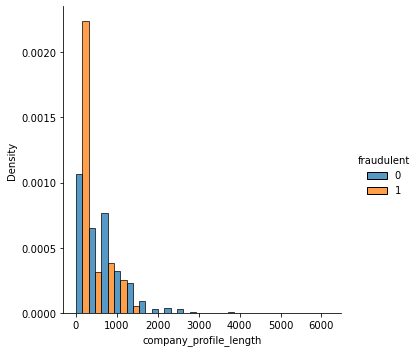

In [32]:
sns.displot(df_na, x='company_profile_length', hue='fraudulent', stat='density', bins=20, common_norm=False, multiple='dodge')

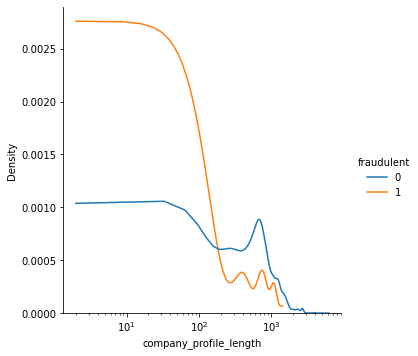

In [33]:
ax=sns.displot(df_na, x='company_profile_length', hue='fraudulent', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

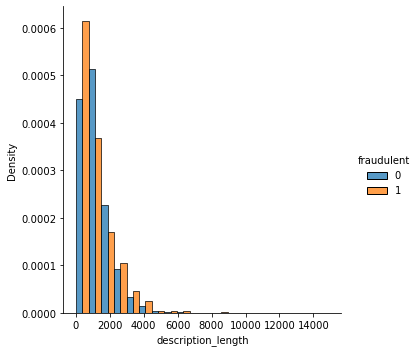

In [34]:
sns.displot(df_na, x='description_length', hue='fraudulent', stat='density', bins=20, common_norm=False, multiple='dodge')

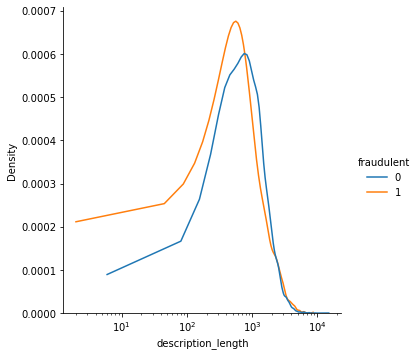

In [35]:
ax=sns.displot(df_na, x='description_length', hue='fraudulent', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

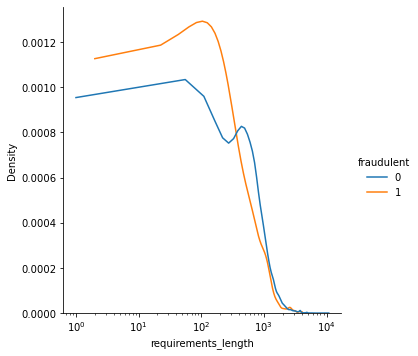

In [36]:
ax=sns.displot(df_na, x='requirements_length', hue='fraudulent', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

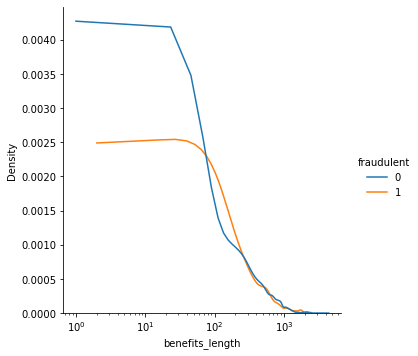

In [37]:
ax=sns.displot(df_na, x='benefits_length', hue='fraudulent', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

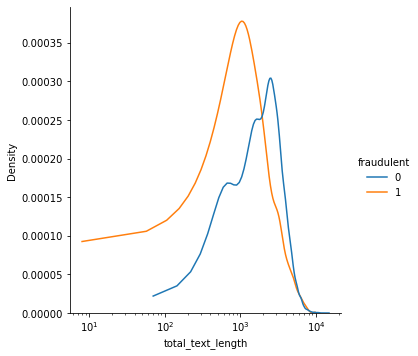

In [38]:
ax=sns.displot(df_na, x='total_text_length', hue='fraudulent', kind='kde', common_norm=False, cut=0)
ax.set(xscale="log")

And it is evidently clear that fake ads generally have shorter textual contents.

# Examination of Other Features

The following graphs of three binary features show that ads of jobs involving **telecommuting**, do not have **company logo** and **screening questions** are more likely to be fake. Among the three features, the absence of company logo is the most indicative, with 16% of ads without company logo to be fake, while only 2% of ads with company logo are fraudulent.

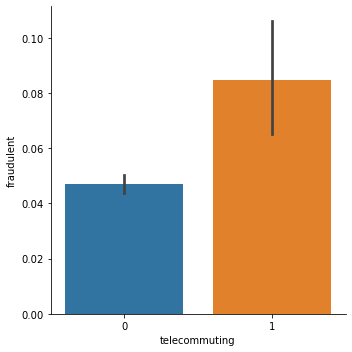

In [39]:
sns.catplot(data=df_na, y='fraudulent', x='telecommuting', kind='bar')

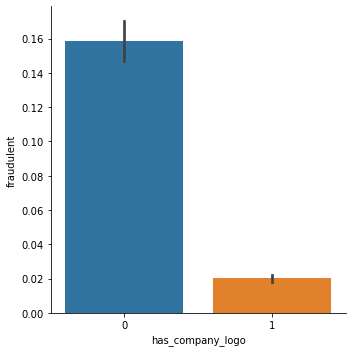

In [40]:
sns.catplot(data=df_na, y='fraudulent', x='has_company_logo', kind='bar')

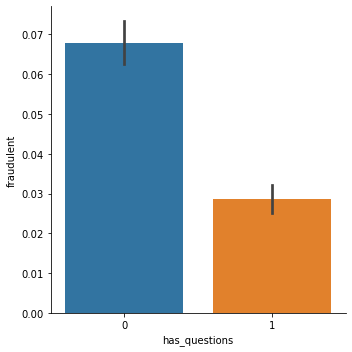

In [41]:
sns.catplot(data=df_na, y='fraudulent', x='has_questions', kind='bar')

In terms of **employment type**, ads which specify "full-time", "contract" and "temporary" are less likely to be fake. For **required experience**, ads which specify "associate","mid-senior level" and "internship" are less likely to be fake. And for **required education**, each category has more or less the same low fraudulent rates, with the exception of "some high school coursework", where the fraudulent rate is 75%. For **function** listed, "administrative" with a fraudulent rate about 20% stands out.

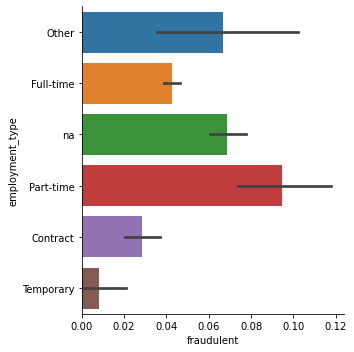

In [42]:
sns.catplot(data=df_na, x='fraudulent', y='employment_type', kind='bar')

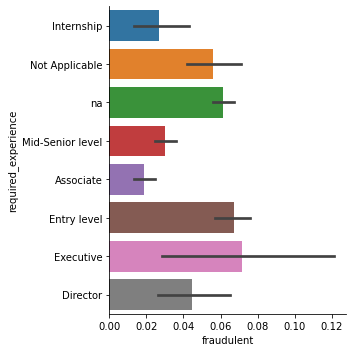

In [43]:
sns.catplot(data=df_na, x='fraudulent', y='required_experience', kind='bar')

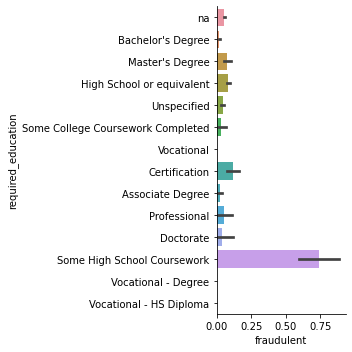

In [44]:
sns.catplot(data=df_na, x='fraudulent', y='required_education', kind='bar')

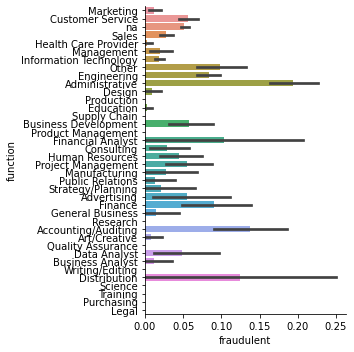

In [45]:
sns.catplot(data=df_na, x='fraudulent', y='function', kind='bar')

As for the 131 categories of **industry** listed, the most common in fake ads is "oil and energy". Among ads in that industry, the fraud rate 37.8% is also among the highest, though some isolated cases make the fraud rates of some industries like ranching, military and animation even higher.

In [46]:
df_na.industry.value_counts()[:20]

na                                     4837
Information Technology and Services    1711
Computer Software                      1362
Internet                               1054
Education Management                    819
Marketing and Advertising               818
Financial Services                      748
Hospital & Health Care                  483
Consumer Services                       348
Telecommunications                      326
Oil & Energy                            286
Retail                                  223
Real Estate                             166
Accounting                              159
Construction                            152
E-Learning                              138
Design                                  127
Staffing and Recruiting                 127
Management Consulting                   127
Health, Wellness and Fitness            123
Name: industry, dtype: int64

In [47]:
fake.industry.value_counts()[:20]

na                                     270
Oil & Energy                           108
Accounting                              57
Hospital & Health Care                  49
Marketing and Advertising               45
Financial Services                      35
Information Technology and Services     32
Telecommunications                      26
Consumer Services                       24
Real Estate                             23
Leisure, Travel & Tourism               20
Health, Wellness and Fitness            15
Hospitality                             14
Computer Networking                     12
Staffing and Recruiting                  8
Insurance                                6
Human Resources                          6
Management Consulting                    6
Computer & Network Security              5
Entertainment                            5
Name: industry, dtype: int64

In [48]:
real.industry.value_counts()[:20]

na                                     4567
Information Technology and Services    1679
Computer Software                      1357
Internet                               1054
Education Management                    819
Marketing and Advertising               773
Financial Services                      713
Hospital & Health Care                  434
Consumer Services                       324
Telecommunications                      300
Retail                                  218
Oil & Energy                            178
Construction                            149
Real Estate                             143
E-Learning                              136
Design                                  123
Management Consulting                   121
Staffing and Recruiting                 119
Insurance                               115
Automotive                              112
Name: industry, dtype: int64

In [49]:
industry=pd.crosstab(df_na.industry, df_na.fraudulent, normalize='index', margins=True)
industry.iloc[:,1].sort_values(ascending=False)[:20].to_frame(name='fraud rates')

,fraud rates
industry,
Ranching,1.000000
Military,0.500000
Animation,0.400000
Oil & Energy,0.377622
Accounting,0.358491
Computer Networking,0.279070
"Leisure, Travel & Tourism",0.277778
Executive Office,0.250000
Defense & Space,0.222222


The examination of **title** again reveals that some fake jobs ads emphasise **money earned in dollar sign**. 6.8% of fake ads have this characteristic, but only 0.4% of real ads do so.

In [50]:
df_na.title.value_counts()[:20]

English Teacher Abroad                                309
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate                            141
English Teacher Abroad                                 94
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Account Manager                                        74
Customer Service Associate - Part Time                 72
Web Developer                                          65
Project Manager                                        60
Graduates: English Teacher Abroad                      57
Beauty & Fragrance consultants needed                  55
Customer Service Representative                        51
Administrative Assistant                               47
Office Manager                                         46
Product Manager                                        46
Marketing Manager                                      45
Web Designer  

In [51]:
real.title.value_counts()[:20]

English Teacher Abroad                                309
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate                            141
English Teacher Abroad                                 94
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Account Manager                                        72
Customer Service Associate - Part Time                 72
Web Developer                                          65
Project Manager                                        60
Graduates: English Teacher Abroad                      57
Beauty & Fragrance consultants needed                  55
Product Manager                                        46
Marketing Manager                                      45
Senior Software Engineer                               44
Office Manager                                         44
Web Designer                                           44
iOS Developer 

In [52]:
fake.title.value_counts()[:20]

Cruise Staff Wanted *URGENT*                                            20
Home Based Payroll Typist/Data Entry Clerks Positions Available         20
Data Entry Admin/Clerical Positions - Work From Home                    18
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Data Entry                                                               9
Agency Sales Managers $150-$175,000/yr                                   9
Payroll Clerk                                                            9
 Payroll Data Entry Clerk Position - Earn $100-$200 Daily                6
Call Center Representativ

In [53]:
fake.title.str.contains('$', regex=False).value_counts(normalize=True)

False    0.932243
True     0.067757
Name: title, dtype: float64

In [54]:
real.title.str.contains('$', regex=False).value_counts(normalize=True)

False    0.995759
True     0.004241
Name: title, dtype: float64

The **locations** in the dataset include states and cities. To simplify the analysis, I only consider the countries, where 84% of fake ads list the US as location, while 58% of real ads come from the US.

In [55]:
df_na.location.value_counts()[:20]

GB, LND, London          718
US, NY, New York         644
US, CA, San Francisco    466
GR, I, Athens            462
na                       341
US, ,                    339
US, TX, Houston          265
US, IL, Chicago          249
US, DC, Washington       249
DE, BE, Berlin           221
NZ, N, Auckland          217
US, CA, Los Angeles      180
GB, , London             177
US, TX, Austin           173
US, CA, San Diego        162
GB, ,                    138
GB, LND,                 131
US, GA, Atlanta          129
US, OR, Portland         128
CA, ON, Toronto          119
Name: location, dtype: int64

In [56]:
real.location.value_counts()[:20]

GB, LND, London          716
US, NY, New York         624
GR, I, Athens            462
US, CA, San Francisco    455
na                       322
US, ,                    311
US, DC, Washington       247
US, IL, Chicago          245
DE, BE, Berlin           221
NZ, N, Auckland          217
GB, , London             176
US, TX, Houston          174
US, TX, Austin           166
US, CA, San Diego        161
US, CA, Los Angeles      157
GB, ,                    137
GB, LND,                 129
US, OR, Portland         127
US, GA, Atlanta          124
US, MA, Boston           115
Name: location, dtype: int64

In [57]:
fake.location.value_counts()[:20]

US, TX, Houston          91
AU, NSW, Sydney          30
US, ,                    28
US, CA, Bakersfield      24
US, CA, Los Angeles      23
US, CA, San Mateo        22
US, NY, New York         20
na                       19
US, TX, AUSTIN           14
US, CA, San Jose         14
US, TX, DALLAS           11
US, MD, Baltimore        11
US, CA, San Francisco    11
US, CA,                   9
US, OH, Cincinnati        8
US, NY, NY                8
MY, ,                     7
US, TX, Austin            7
US, CA, LOS ANGELES       6
CA, ON, Toronto           6
Name: location, dtype: int64

In [58]:
df.location=df.location.str[:2]

In [59]:
df.location.value_counts()

US    10460
GB     2329
GR      938
CA      450
DE      382
      ...  
SI        1
PE        1
SD        1
UG        1
KH        1
Name: location, Length: 90, dtype: int64

In [60]:
real.location=real.location.str[:2]
real.location.value_counts(normalize=True).head(10)

C:\Users\szeye_000\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


US    0.581676
GB    0.137729
GR    0.056023
CA    0.026160
DE    0.022816
NZ    0.019710
na    0.019232
IN    0.016066
AU    0.010392
PH    0.007824
Name: location, dtype: float64

In [61]:
fake.location=fake.location.str[:2]
fake.location.value_counts(normalize=True).head(10)

US    0.842290
AU    0.045561
GB    0.026869
na    0.022196
MY    0.014019
CA    0.014019
QA    0.007009
BH    0.005841
IN    0.004673
PL    0.003505
Name: location, dtype: float64

The **salary range** of the dataset has quite a large number of unique values. But since more than 80% of ads do not list it, apparently the only thing that matters is whether the ad omits this field, as noted earlier.

In [62]:
df.salary_range.value_counts()

0-0            141
40000-50000     66
30000-40000     54
45000-67000     36
25000-30000     36
              ... 
60-75            1
27500-36000      1
20-22            1
110-120          1
3700-3800        1
Name: salary_range, Length: 874, dtype: int64

In [63]:
real.salary_range.value_counts(normalize=True)

na               0.844353
0-0              0.008183
40000-50000      0.003882
30000-40000      0.002986
45000-67000      0.002150
                   ...   
300000-325000    0.000060
27500-36000      0.000060
20-22            0.000060
110-120          0.000060
15500-16500      0.000060
Name: salary_range, Length: 829, dtype: float64

In [64]:
fake.salary_range.value_counts(normalize=True)

na                 0.741822
7200-1380000       0.011682
30000-50000        0.009346
250000-500000      0.008178
28000-32000        0.007009
                     ...   
34000-50000        0.001168
2000-2000          0.001168
6266624-8582080    0.001168
30000-100000       0.001168
0-30000            0.001168
Name: salary_range, Length: 118, dtype: float64

# Preliminary Textual Analysis

Then I join the open textual fields for analysis. The first thing to consider is checking whether external links are characteristics of fake job ads. Comparisons reveal while real and fake ads have **#URL** links in more or less same rates, 20% of fake ads have **#EMAIL** links but less than 7% of real ads do so, and 9.2% of fake ads have **#PHONE** links while only 2.6% of real ads have them.

In [65]:
real_text=real.title+' '+real.company_profile+' '+real.description+' '+real.requirements+' '+real.benefits

In [66]:
real_text_frame=real_text.to_frame(name='text')

In [67]:
fake_text=fake.title+' '+fake.company_profile+' '+fake.description+' '+fake.requirements+' '+fake.benefits

In [68]:
fake_text_frame=fake_text.to_frame(name='text')

In [69]:
fake_text.str.contains('#URL', regex=False).value_counts(normalize=True)

False    0.690421
True     0.309579
dtype: float64

In [70]:
real_text.str.contains('#URL', regex=False).value_counts(normalize=True)

False    0.684346
True     0.315654
dtype: float64

In [71]:
fake_text.str.contains('#EMAIL', regex=False).value_counts(normalize=True)

False    0.799065
True     0.200935
dtype: float64

In [72]:
real_text.str.contains('#EMAIL', regex=False).value_counts(normalize=True)

False    0.931733
True     0.068267
dtype: float64

In [73]:
fake_text.str.contains('#PHONE', regex=False).value_counts(normalize=True)

False    0.90771
True     0.09229
dtype: float64

In [74]:
real_text.str.contains('#PHONE', regex=False).value_counts(normalize=True)

False    0.9739
True     0.0261
dtype: float64

In [75]:
fake_text[9835]

"Director of Product Management #URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389f1bbaf2a1cb071e3f2b6e7e# and Aptitude Staffing Solutions have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model.\xa0 Our focus is to help develop and achieve your career goals while makeing a solid geographical, cultural and professional fiit when leveraging your career into your new and exciting professional venture!Please direct all communications throughout this process to the HR department at Aptitude Staffing Solutions#EMAIL_0c020555b4dbc1c1e03d03c46cc181bcfde81bf5b20fea95d1bc7dc64c79814c#Darren Lawson | VP of Recruiting | #EMAIL_f4da338e899ddba983ac771b001681d1d2d93b3327ddc420a15f4e5a310071a9#\xa0| #PHONE_90d33c9d7ec1484aebfe37b153d677decc6f5f53b316489ed24061544c04eb66# Director, Product Management | San Mateo, CASan Mateo, CA, United States Seeking a talented and experienced Director of Product Management to lead the design of key comp

For **text preprocessing**, I use the function by [Jiahao Weng](https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f). It includes remove HTML tags, remove extra whitespaces, convert accented characters to ASCII characters, expand contractions, remove special characters, lowercase all texts, convert number words to numeric form, remove numbers, remove stopwords and lemmatization. Then I look into the most common words in real and fake job ads.

In [79]:
#!pip install word2number

In [77]:
#!pip install --upgrade setuptools

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.0.5 requires pyqt5<5.13, which is not installed.
spyder 5.0.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.



  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.2.0
    Uninstalling setuptools-60.2.0:
      Successfully uninstalled setuptools-60.2.0


In [81]:
#!pip install contractions

In [82]:
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions

nlp = spacy.load("en_core_web_sm")

# exclude words from spacy stopwords list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text


def text_preprocessing(text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if remove_html == True: #remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return clean_text

In [83]:
real_text_frame['clean']=real_text_frame.apply(lambda x: text_preprocessing(x['text']), axis=1)
real_text_frame['clean']=real_text_frame.apply(lambda x: " ".join(x['clean']), axis=1)

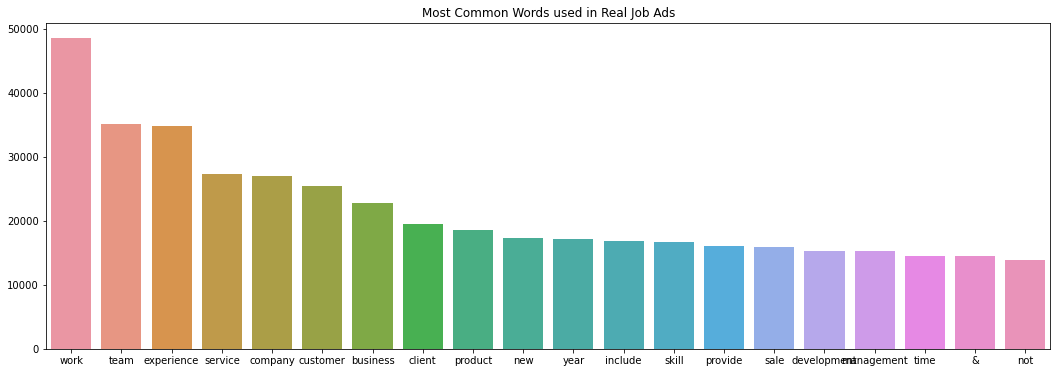

In [84]:
from collections import Counter

real_total_text = [text for text in real_text_frame['clean']]
real_total_text = ' '.join(real_total_text).split()

real_counts = Counter(real_total_text)

real_common_words = [word[0] for word in real_counts.most_common(20)]
real_common_counts = [word[1] for word in real_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=real_common_words, y=real_common_counts)
plt.title('Most Common Words used in Real Job Ads')
plt.show()

In [85]:
fake_text_frame['clean']=fake_text_frame.apply(lambda x: text_preprocessing(x['text']), axis=1)
fake_text_frame['clean']=fake_text_frame.apply(lambda x: " ".join(x['clean']), axis=1)

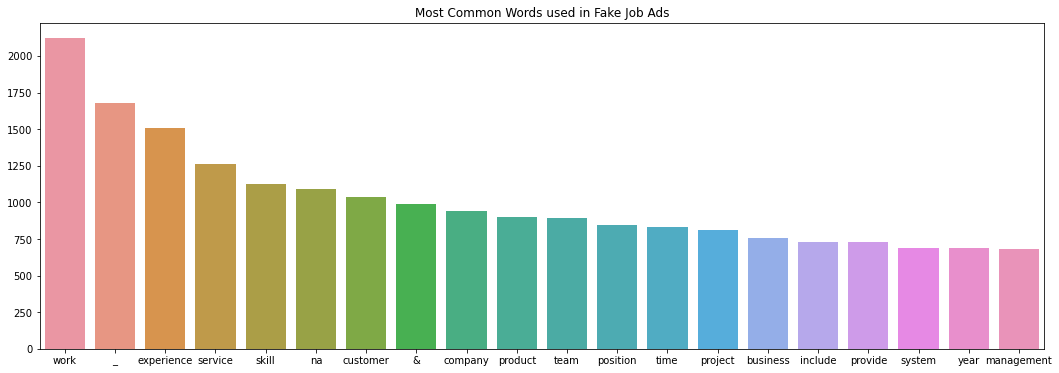

In [86]:
from collections import Counter

fake_total_text = [text for text in fake_text_frame['clean']]
fake_total_text = ' '.join(fake_total_text).split()

fake_counts = Counter(fake_total_text)

fake_common_words = [word[0] for word in fake_counts.most_common(20)]
fake_common_counts = [word[1] for word in fake_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=fake_common_words, y=fake_common_counts)
plt.title('Most Common Words used in Fake Job Ads')
plt.show()

In this preliminary analysis it is not apparent that any keywords can separate real ads and fake ads, as most common words such as "work", "experience", "service" and "skill" are featured in both classes of text. A bag-of-words analysis should be better in doing this job. But it is noticeable that the dummy word "**na**" for missing values is featured high in the most common words list in fake ads.

# Features Construction

To recap the above observations, the following characteristics have potentials to identify fake job ads and to be constructed as features for machine learning:
* title: mention '$'
* location: from US or AU
* salary range: less likely to omit
* company profile: more likely to omit
* textual descriptions tend to be shorter
* textual descriptions more likely to include links for email and phone contacts

For the missing values, in categorical fields "na" would be used as a category, but in the combined text it is replaced by empty space to avoid overlapping with the newly created features denoting absence of values. Furthermore, the less frequently appeared countries in the location column are simplified as "other".

In [87]:
finaldf=df.copy()

In [88]:
finaldf['missing_company_profile']=finaldf.company_profile.isnull().astype(int)

In [89]:
finaldf['missing_salary_range']=finaldf.company_profile.isnull().astype(int)

In [90]:
finaldf.fillna('na', inplace=True)

In [91]:
text_columns=['title','company_profile','description','requirements','benefits']
for column in text_columns:
    finaldf.loc[finaldf[column]=='na', column]=' '

In [92]:
finaldf['title_mention_$']=finaldf.title.str.contains('$', regex=False).astype(int)

In [93]:
def location_transform(location):
    country_list=['US','GB','CA','DE','NZ','AU','IN','MY','na']
    country=location[:2]
    if country in country_list:
        return country
    else:
        return 'other'
    
finaldf.location=finaldf.apply(lambda x: location_transform(x['location']), axis=1)

In [94]:
finaldf.location.value_counts()

US       10460
other     2800
GB        2329
CA         450
DE         382
na         341
NZ         330
IN         273
AU         213
MY          21
Name: location, dtype: int64

In [95]:
finaldf['text']=finaldf.title+' '+finaldf.company_profile+' '+finaldf.description+' '+finaldf.requirements+' '+finaldf.benefits
finaldf['email_link']=finaldf.text.str.contains('#EMAIL', regex=False).astype(int)
finaldf['phone_link']=finaldf.text.str.contains('#PHONE', regex=False).astype(int)

In [96]:
import math
finaldf['text_length']=finaldf.apply(lambda x: math.log(len(x['text'])+1), axis=1) 
#putting the length in logarithm to transform the skew distribution, add one to avoid the error of log(0)

In [97]:
# creating the "cleaned text" column
finaldf['cleaned_text']=finaldf.apply(lambda x: text_preprocessing(x['text']), axis=1)
finaldf['cleaned_text']=finaldf.apply(lambda x: " ".join(x['cleaned_text']), axis=1)

In [98]:
finaldf

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,function,fraudulent,missing_company_profile,missing_salary_range,title_mention_$,text,email_link,phone_link,text_length,cleaned_text
job_id,,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,US,Marketing,na,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,...,Marketing,0,0,0,0,"Marketing Intern We're Food52, and we've creat...",0,0,7.887584,marketing intern food52 create groundbreaking ...
2,Customer Service - Cloud Video Production,NZ,Success,na,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,Customer Service,0,0,0,0,Customer Service - Cloud Video Production 90 S...,0,0,8.721602,customer service cloud video production second...
3,Commissioning Machinery Assistant (CMA),US,na,na,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,...,na,0,0,0,0,Commissioning Machinery Assistant (CMA) Valor ...,0,0,7.879291,commission machinery assistant cma valor servi...
4,Account Executive - Washington DC,US,Sales,na,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,...,Sales,0,0,0,0,Account Executive - Washington DC Our passion ...,0,0,8.605753,account executive washington dc passion improv...
5,Bill Review Manager,US,na,na,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,...,Health Care Provider,0,0,0,0,Bill Review Manager SpotSource Solutions LLC i...,0,1,8.281471,bill review manager spotsource solution llc gl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,CA,Sales,na,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,...,Sales,0,0,0,0,Account Director - Distribution Vend is looki...,0,0,8.578665,account director distribution vend look awesom...
17877,Payroll Accountant,US,Accounting,na,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,...,Accounting/Auditing,0,0,0,0,Payroll Accountant WebLinc is the e-commerce p...,0,0,8.464003,payroll accountant weblinc e - commerce platfo...
17878,Project Cost Control Staff Engineer - Cost Con...,US,na,na,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,...,na,0,0,0,0,Project Cost Control Staff Engineer - Cost Con...,0,0,7.944137,project cost control staff engineer cost contr...


In [99]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

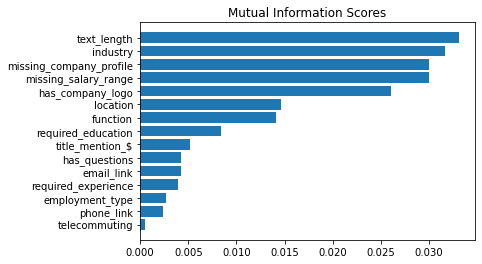

In [100]:
feature_set=['location','missing_salary_range','missing_company_profile','telecommuting','has_company_logo','has_questions',
             'employment_type','required_experience','required_education','industry','function','title_mention_$',
             'email_link','phone_link','text_length']
scores=make_mi_scores(finaldf[feature_set], finaldf['fraudulent'])
plot_mi_scores(scores)

Mutual information scores show that among the non-textual features, "text length", "industry", "missing company profile", "missing salary range" and "has company logo" are the top 5 features that have a relationship with fake job ads.

Then we do one-hot-encoding with the categorical features, make the final features set as X, and separate the column "fraudulent" as y.

In [101]:
finaldf_getdummy=pd.get_dummies(data=finaldf, columns=['location','employment_type','required_experience',
                                                       'required_education','industry','function'])

In [102]:
finaldf_getdummy

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_na
job_id,,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,Marketing,na,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Customer Service - Cloud Video Production,Success,na,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Commissioning Machinery Assistant (CMA),na,na,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,Account Executive - Washington DC,Sales,na,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,Bill Review Manager,na,na,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,Sales,na,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,...,0,0,0,1,0,0,0,0,0,0
17877,Payroll Accountant,Accounting,na,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,...,0,0,0,0,0,0,0,0,0,0
17878,Project Cost Control Staff Engineer - Cost Con...,na,na,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [103]:
X=finaldf_getdummy.drop(['fraudulent','title','department','salary_range','company_profile','description','requirements','benefits'], axis=1)
y=finaldf_getdummy['fraudulent']

In [104]:
X

,telecommuting,has_company_logo,has_questions,missing_company_profile,missing_salary_range,title_mention_$,text,email_link,phone_link,text_length,...,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_na
job_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,"Marketing Intern We're Food52, and we've creat...",0,0,7.887584,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,Customer Service - Cloud Video Production 90 S...,0,0,8.721602,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,Commissioning Machinery Assistant (CMA) Valor ...,0,0,7.879291,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,Account Executive - Washington DC Our passion ...,0,0,8.605753,...,0,0,0,1,0,0,0,0,0,0
5,0,1,1,0,0,0,Bill Review Manager SpotSource Solutions LLC i...,0,1,8.281471,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,0,1,1,0,0,0,Account Director - Distribution Vend is looki...,0,0,8.578665,...,0,0,0,1,0,0,0,0,0,0
17877,0,1,1,0,0,0,Payroll Accountant WebLinc is the e-commerce p...,0,0,8.464003,...,0,0,0,0,0,0,0,0,0,0
17878,0,0,0,0,0,0,Project Cost Control Staff Engineer - Cost Con...,0,0,7.944137,...,0,0,0,0,0,0,0,0,0,1


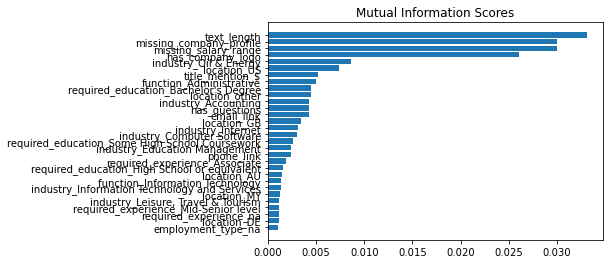

In [105]:
scores=make_mi_scores(X,y)[2:32]
plot_mi_scores(scores)

After one hot encoding, "industry: oil and energy" and "location: US" emerge among features with highest MI scores.

# Sampling and Model Construction Strategy

In dealing with imbalanced classification, two of the most common strategies are undersampling and oversampling. One drawback of undersampling is the undersampled majority class sample may lose some information and be biased, and one drawback of upsampling is it may be prone to overfitting, especially when the upsampling rate is high. 
 
On the other hand, this dataset has rich textual contents for constructing bag-of-words(BoW) models, and also has a large number of features for training a separate model. So to keep the upsampling rate low while using all of the majority class cases, I devise a strategy of dividing the majority class cases into three portions, each combine with the randomly upsampled full set of minority class cases for training three models, and make a ensemble of the three models by simple majority votes.
 
In the dataset, the real ads to fake ads ratio is about 19:1. When we divide the real cases into three portions while keeping the whole fake cases, the ratio becomes about 6.3:1. With an upsampling rate of about 4 times, the ratio can further be reduced to 1:0.6.
 
And the three models are:
1. **A BoW model using simple Countvectorizer and linear support vector machine(SVM)**
1. **A BoW model using TF-IDF vectorizer and random forest model**
1. **A XGBoost classifier model on the non-textual features**
 
The choice of algorithms for modeling also take imbalanced classification as consideration. Both SVM and random forest have inbuilt feature of balancing class weight, and XGBoost is known to be effective on an imbalanced dataset.

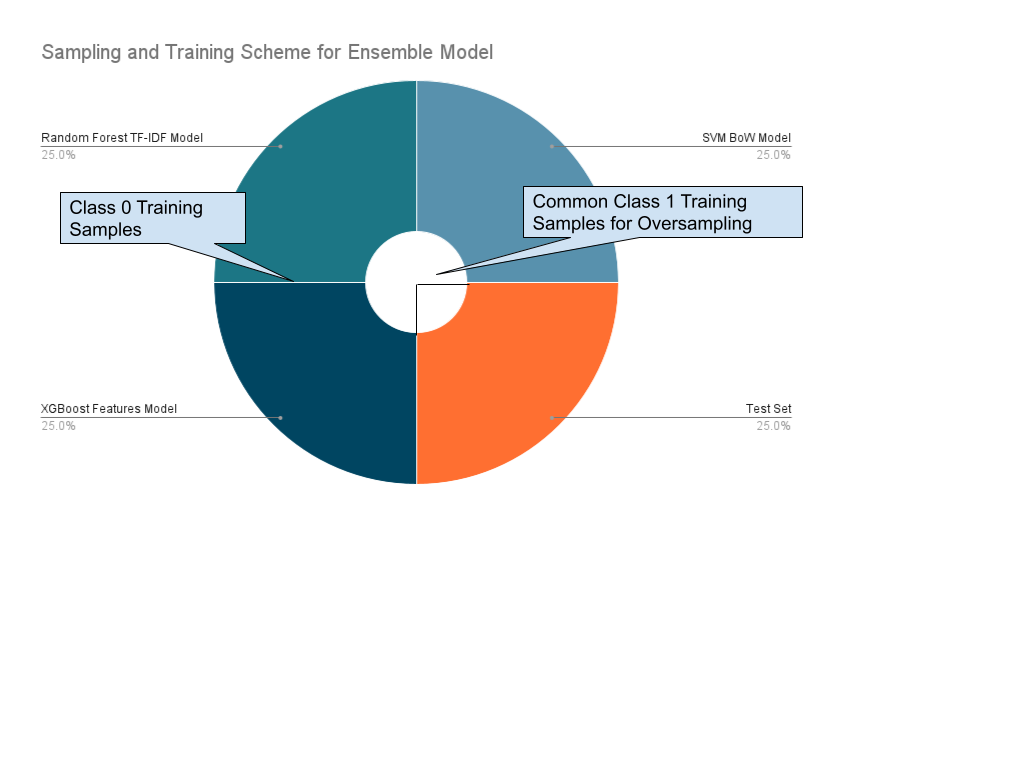

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=50, stratify=y)

In [107]:
X_train1=X_train[y_train==0].iloc[0::3].append(X_train[y_train==1])
X_train2=X_train[y_train==0].iloc[1::3].append(X_train[y_train==1])
X_train3=X_train[y_train==0].iloc[2::3].append(X_train[y_train==1])

In [108]:
y_train1=y_train[y_train==0].iloc[0::3].append(y_train[y_train==1])
y_train2=y_train[y_train==0].iloc[1::3].append(y_train[y_train==1])
y_train3=y_train[y_train==0].iloc[2::3].append(y_train[y_train==1])

In [109]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.6, random_state= 42)
X_train1_resampled, y_train1_resampled = ros.fit_resample(X_train1, y_train1)
X_train2_resampled, y_train2_resampled = ros.fit_resample(X_train2, y_train2)
X_train3_resampled, y_train3_resampled = ros.fit_resample(X_train3, y_train3)

# SVM BoW Model

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

vectorizer = CountVectorizer(ngram_range=(1,2)) # looking for both unigrams and bigrams
clf = LinearSVC(C=0.01, class_weight='balanced', random_state=42)
bowpipe = Pipeline([('vectorizer', vectorizer), ('clf', clf)])
bowpipe.fit(X_train1_resampled['cleaned_text'], y_train1_resampled)
bow_predict = bowpipe.predict(X_test['cleaned_text'])

In [111]:
from sklearn.metrics import accuracy_score, classification_report
print("accuracy:", accuracy_score(y_test, bow_predict))
print(classification_report(y_test, bow_predict))


accuracy: 0.9768181818181818
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4186
           1       0.73      0.84      0.78       214

    accuracy                           0.98      4400
   macro avg       0.86      0.91      0.88      4400
weighted avg       0.98      0.98      0.98      4400



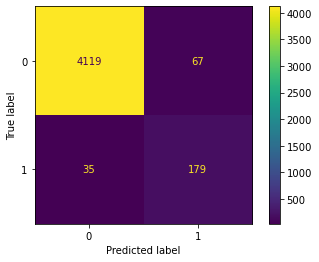

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_bow=confusion_matrix(y_test, bow_predict)
disp=ConfusionMatrixDisplay(confusion_matrix=cm_bow)
disp.plot()
plt.show()

In [113]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass0 = coefs_with_fns[:N]
    topClass1 = coefs_with_fns[:-(N + 1):-1]
    print("Class 0 best: ")
    for feat in topClass0:
        print(feat)
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)

print("Top 30 features used to predict: ")
printNMostInformative(vectorizer, clf, 30)
transform = vectorizer.fit_transform(X_train1_resampled['cleaned_text'], y_train1_resampled)

vocab = vectorizer.get_feature_names()
for i in range(len(X_train1_resampled['cleaned_text'])):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))

Top 30 features used to predict: 
Class 0 best: 
(-0.10518760274539, 'digital')
(-0.10485397348956528, 'english')
(-0.08009225957321474, 'php')
(-0.07990102302100188, 'developer')
(-0.07902804641277285, 'order')
(-0.07677602348124193, 'tech')
(-0.07345923427836276, 'fun')
(-0.07046741733582906, 'experienced')
(-0.06896793780451876, 'agency')
(-0.06841968141190599, 'user')
(-0.06666718609304659, 'exceptional')
(-0.06510782259260481, 'fast')
(-0.06466620902361248, 'update')
(-0.06377771976591214, 'year')
(-0.06246288151028023, 'recruitment')
(-0.06146860118795352, 'client')
(-0.06123645831015411, 'have')
(-0.061017193504706566, 'reliable')
(-0.05992376798192639, 'right')
(-0.056837359304028334, 'driver')
(-0.05591778575399471, 'hardware')
(-0.054402833578407625, 'career')
(-0.05399989286850536, 'implement')
(-0.053855794505397174, 'etc')
(-0.05368713347035106, 'way')
(-0.05351743642906993, 'startup')
(-0.052851672085284275, 'creative')
(-0.05259804675713224, 'software')
(-0.0525608744157

A bag-of-word model simply keeps counts of occurance of each word in the text. By feeding it into a machine learning algorithm, we hope the algorithm can identify keywords that can distinguish fake job ads from the real ones. Linear SVM is known to be working quickly on high dimensional data and is highly interpretable. I use [Susan Li's](https://www.kdnuggets.com/2018/09/machine-learning-text-classification-using-spacy-python.html) function for listing the top textual features used for predictions, and it reveals that some of the words raised in earlier discussion like "**earn**", "**immediate**", "**cash**", "**money**", "**apply link**", "**phone**", "**work home**" emerge as keywords for predictions, while certain top words related to "**northwestern hospital build website**" apparently learned from a series of fake ads in the sample.

# Random Forest TF-IDF BoW Model

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

t_vectorizer = TfidfVectorizer(ngram_range=(1,2))
t_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
t_bowpipe = Pipeline([('vectorizer', t_vectorizer), ('clf', t_clf)])
t_bowpipe.fit(X_train2_resampled['cleaned_text'], y_train2_resampled)
t_bow_predict = t_bowpipe.predict(X_test['cleaned_text'])

In [115]:
print("accuracy:", accuracy_score(y_test, t_bow_predict))
print(classification_report(y_test, t_bow_predict))

accuracy: 0.9815909090909091
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4186
           1       0.84      0.76      0.80       214

    accuracy                           0.98      4400
   macro avg       0.92      0.88      0.90      4400
weighted avg       0.98      0.98      0.98      4400



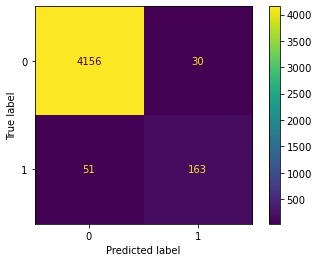

In [116]:
cm_t_bow=confusion_matrix(y_test, t_bow_predict)
disp=ConfusionMatrixDisplay(confusion_matrix=cm_t_bow)
disp.plot()
plt.show()

In [117]:
import eli5
eli5.explain_weights(t_bowpipe, vec=t_vectorizer, top=30, targets=y_train2_resampled)

Weight,Feature
0.0042 ± 0.0295,data entry
0.0036 ± 0.0281,skill
0.0031 ± 0.0238,grow
0.0030 ± 0.0209,start
0.0030 ± 0.0224,passionate
0.0030 ± 0.0185,team
0.0026 ± 0.0264,work home
0.0024 ± 0.0165,build
0.0023 ± 0.0170,user
0.0023 ± 0.0190,medium


TD-IDF(term frequency–inverse document frequency) changes the word counts of BoW model by suppressing the importance of words occurring across texts, thus concentrating on unique words that appear frequently in a particular text. The eli5 library can reveal the textual features carry the most weight i the random forest model, but don't distinguish whether they are used to predict real or fake ads, but we can see certain words like "**earn**", "**work home**", "**no experience**" appear again. And compared with the SVM BoW model, which has more false positives than false negatives, the random forest TF-IDF BoW Model has more false negatives than false positives.

# XGBoost Features Model

In [118]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = ['text_length']
ct = ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough') 
# Standardize the value of numerical features to avoid overweighted in training

In [119]:
Xtr3=X_train3_resampled.drop(['text','cleaned_text'], axis=1)
Xte=X_test.drop(['text','cleaned_text'], axis=1)

In [120]:
import xgboost as xgb
from xgboost import XGBClassifier
xgbc=XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='error',
                   eta=0.7, gamma=0,
                  max_depth=7, min_child_weight=1, random_state=42)
xgbcpipe = Pipeline([('preprocessor', ct), ('clf', xgbc)])
xgbcpipe.fit(Xtr3, y_train3_resampled)
xgbc_predict = xgbcpipe.predict(Xte)

In [121]:
print("accuracy:", accuracy_score(y_test, xgbc_predict))
print(classification_report(y_test, xgbc_predict))

accuracy: 0.9597727272727272
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4186
           1       0.56      0.79      0.66       214

    accuracy                           0.96      4400
   macro avg       0.78      0.88      0.82      4400
weighted avg       0.97      0.96      0.96      4400



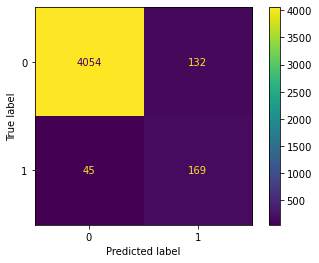

In [122]:
cm_xgbc=confusion_matrix(y_test, xgbc_predict)
disp=ConfusionMatrixDisplay(confusion_matrix=cm_xgbc)
disp.plot()
plt.show()

In [123]:
#showing importance by features using xgboost
pd.DataFrame({'Variable':Xtr3.columns,
              'Importance':[round(v,2) for v in xgbc.feature_importances_]}) \
  .sort_values('Importance', ascending=False) \
  .style.bar(color=['grey', 'lightblue'], align='zero')

,Variable,Importance
4,missing_salary_range,0.110000
135,industry_Oil & Energy,0.060000
65,industry_Computer & Network Security,0.050000
108,industry_Internet,0.030000
37,required_education_High School or equivalent,0.030000
36,required_education_Doctorate,0.030000
13,location_IN,0.030000
14,location_MY,0.030000
18,location_other,0.020000
59,industry_Business Supplies and Equipment,0.020000


The non-textual features model, even using the highly powerful XGBoost algorithm, still has lower accuracy, particularly it has a large number of false positives, perhaps reflecting that without textual information it is not enough to distinguish truly fake ads from the genuine ones. And the feature importance figures show that it is dominated by variables of industry, required education and location, while missing salary range becomes the top one.

# Making the Ensemble Model

The ensemble model is made in a simple way. We have the predictions of the three models, where 1 denotes a prediction of a fake ad, adding the scores of each record, and when the total score is 2 or 3, it has the majority vote of classified as fraudulent, otherwise it is classified as real.

In [124]:
ensemble_test_score=[bow_predict[i]+t_bow_predict[i]+xgbc_predict[i] for i in range(len(bow_predict))]
ensemble_test_predict=[int(i > 1) for i in ensemble_test_score]

In [125]:
print("accuracy:", accuracy_score(y_test, ensemble_test_predict))
print(classification_report(y_test, ensemble_test_predict))

accuracy: 0.9856818181818182
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4186
           1       0.87      0.83      0.85       214

    accuracy                           0.99      4400
   macro avg       0.93      0.91      0.92      4400
weighted avg       0.99      0.99      0.99      4400



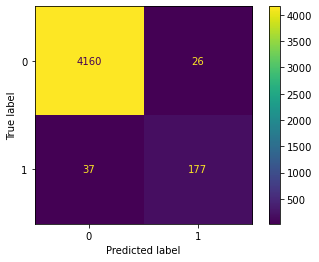

In [126]:
cm_ensemble_test=confusion_matrix(y_test, ensemble_test_predict)
disp=ConfusionMatrixDisplay(confusion_matrix=cm_ensemble_test)
disp.plot()
plt.show()

The accuracy (98.6%) and f1 scores (0.85) of the ensemble model is higher than the SVM BoW model (97.7% and 0.78), the random forest TF-IDF BoW model (98.3% and 0.81) and the XGBoost features model (96.0% and 0.66).

In [127]:
#apply the ensemble models for the whole dataset
bow_svm_predict_full=bowpipe.predict(X['cleaned_text'])
bow_rf_predict_full=t_bowpipe.predict(X['cleaned_text'])
xgbc_predict_full = xgbcpipe.predict(X.drop(['text','cleaned_text'], axis=1))

In [128]:
finaldf['bow_svm_predict_full']=bow_svm_predict_full
finaldf['bow_rf_predict_full']=bow_rf_predict_full
finaldf['xgbc_predict_full']=xgbc_predict_full

In [129]:
finaldf['ensemble_total']=finaldf['bow_svm_predict_full']+finaldf['bow_rf_predict_full']+finaldf['xgbc_predict_full']
finaldf['ensemble_predict']=finaldf.apply(lambda x: int(x['ensemble_total'] >1), axis=1)

In [130]:
print("accuracy:", accuracy_score(y, finaldf['ensemble_predict']))
print(classification_report(y, finaldf['ensemble_predict']))

accuracy: 0.9942042161486448
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16743
           1       0.93      0.96      0.94       856

    accuracy                           0.99     17599
   macro avg       0.96      0.98      0.97     17599
weighted avg       0.99      0.99      0.99     17599



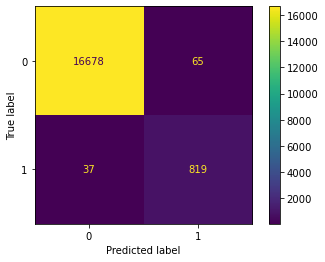

In [131]:
cm_ensemble=confusion_matrix(y, finaldf['ensemble_predict'])
disp=ConfusionMatrixDisplay(confusion_matrix = cm_ensemble)
disp.plot()
plt.show()

When we apply the ensemble model for the whole dataset, the numbers look even more impressive. But as each component model has seen 1/4 of class 0 data and 3/4 of class 1 data, the numbers are somehow inflated.

The following analysis shows that among the correctly predicted fake ads which get 2 votes and just pass the majority threshold, the 2 votes are coming from all three combinations, indicating the three component models complement each other.

In [132]:
tp_2pt=finaldf[(finaldf.ensemble_predict==1) & (finaldf.fraudulent==1) & (finaldf.ensemble_total==2)]

In [133]:
len(tp_2pt[tp_2pt.bow_svm_predict_full==0])

3

In [134]:
len(tp_2pt[tp_2pt.bow_rf_predict_full==0])

15

In [135]:
len(tp_2pt[tp_2pt.xgbc_predict_full==0])

24

# Evaluation of Incorrect Classifications

Still we should examine cases of incorrect classifications to see what can be improved.

In [136]:
fn=finaldf[(finaldf.ensemble_predict==0) & (finaldf.fraudulent==1)]

In [137]:
fn

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,text,email_link,phone_link,text_length,cleaned_text,bow_svm_predict_full,bow_rf_predict_full,xgbc_predict_full,ensemble_total,ensemble_predict
job_id,,,,,,,,,,,,,,,,,,,,,
1203,Big Data Engineer,US,na,na,,Position: Big Data EngineerLocation: San Fran...,Responsibilities:Ability to analyze business n...,,0,0,...,Big Data Engineer Position: Big Data Engine...,0,0,8.145840,big data engineer position big datum engineerl...,0,0,0,0,0
1421,Informatica/ Etl Tester,US,IT,75000-80000,,Position: Informatica Tester Location: Herndo...,,,0,0,...,Informatica/ Etl Tester Position: Informatic...,0,0,5.645447,informatica/ etl tester position informatica t...,0,1,0,1,0
2445,Urgent Requirement For The Position Technical ...,US,na,55-65,,1. Technical Lead - Rhomobile Technical Mob...,Requirement / JD: Drive the mobile app develop...,,0,0,...,Urgent Requirement For The Position Technical ...,1,1,7.483244,urgent requirement position technical lead rho...,0,0,0,0,0
2617,Developer and Database Administrator Pittsbur...,US,na,na,,This position is a mixture of Developer and Da...,Job Requirements EXPERIENCE· Minimum of 5 year...,Salary:82K,0,0,...,Developer and Database Administrator Pittsbur...,0,0,8.212568,developer database administrator pittsburgh pa...,0,0,0,0,0
2893,Marketing Database Decision Strategy Consultant,US,na,80000-200000,,Looking for a modeling manager who is self-sta...,Preferred Skills Experience with SAS E-Miner o...,Salary: 180kIf you have all the necesary skill...,0,0,...,Marketing Database Decision Strategy Consultan...,1,0,8.196988,marketing database decision strategy consultan...,0,0,1,1,0
3176,Earn the Income You Deserve,US,na,na,,Prepare yourself to learn about an exciting wa...,Professional mannerPositive outlookAbility to ...,"If you have a laptop, phone and a strong desir...",1,0,...,Earn the Income You Deserve Prepare yourself...,0,0,7.497207,earn income deserve prepare learn exciting way...,1,0,0,1,0
3439,FULL-TIME opportunity for Technical Project m...,US,na,80000-85000,,Role: Technical Project ManagerLocation is Atl...,,,0,0,...,FULL-TIME opportunity for Technical Project m...,0,0,6.311735,time opportunity technical project manager rol...,0,0,0,0,0
4449,Oil/Gas Asset Manager,US,na,na,,"Position SummaryThe Asset Manager will plan, d...",Minimum Qualifications:The ideal candidate wil...,,0,0,...,Oil/Gas Asset Manager Position SummaryThe As...,0,0,8.513587,oil gas asset manager position summarythe asse...,0,0,1,1,0
5563,Administrative Assistant,US,Administrative,25000-40000,With decades of experience and more than 5000 ...,MSX International is currently seeking an Admi...,The ideal candidate will have a high school De...,"401k Health benefits, Dental, Child care, Vaca...",0,1,...,Administrative Assistant With decades of exper...,0,0,7.967280,administrative assistant decade experience ind...,0,0,0,0,0


In [138]:
fn.loc[1203]

title                                                      Big Data Engineer
location                                                                  US
department                                                                na
salary_range                                                              na
company_profile                                                             
description                Position:  Big Data EngineerLocation: San Fran...
requirements               Responsibilities:Ability to analyze business n...
benefits                                                                    
telecommuting                                                              0
has_company_logo                                                           0
has_questions                                                              0
employment_type                                                     Contract
required_experience                                         Mid-Senior level

In [139]:
eli5.show_prediction(clf, X['cleaned_text'].loc[1203], show_feature_values=True,
                        vec=vectorizer, targets=[0,1], target_names=['real','fake'], top=20)

In [140]:
eli5.show_prediction(t_clf, X['cleaned_text'].loc[1203], show_feature_values=True,
                        vec=t_vectorizer, targets=[0,1], target_names=['real','fake'], top=20)

In [141]:
xgbc.get_booster().feature_names=list(X.drop(['text','cleaned_text'], axis=1).columns)
eli5.show_prediction(xgbc, X.drop(['text','cleaned_text'], axis=1).loc[1203], 
                     feature_names=list(X.drop(['text','cleaned_text'], axis=1).columns),
                     show_feature_values=True,
                     targets=[0,1], target_names=['real','fake'])

Among the 36 false negative cases, this one which makes all 3 component models get it wrong. The content looks genuine and without all the telltale words, so it escapes the detection of both BoW models. And on the features side, though it has no company profile and company logo, it seems that it does not share many common features with other fake ads to make the XGBoost features model raise the flag.

In [142]:
fp=finaldf[(finaldf.ensemble_predict==1) & (finaldf.fraudulent==0)]

In [143]:
fp.sample(15, random_state=56)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,text,email_link,phone_link,text_length,cleaned_text,bow_svm_predict_full,bow_rf_predict_full,xgbc_predict_full,ensemble_total,ensemble_predict
job_id,,,,,,,,,,,,,,,,,,,,,
1157,Finance Assistant,AU,finance,na,,Our Company has a new position available for a...,Coinciding with your previous background as a ...,,0,0,...,Finance Assistant Our Company has a new posi...,1,0,7.208600,finance assistant company new position availab...,1,0,1,2,1
11123,Hiring for all FOH and BOH Positions!,US,na,na,,Trudy’s is always looking for the best!The ben...,,,0,0,...,Hiring for all FOH and BOH Positions! Trudy’...,0,0,6.107023,hire foh boh position trudy look best!the bene...,1,1,0,2,1
9628,Server wanted!,US,na,na,,Currently hiring 3 Servers for cocktail and fo...,,,0,0,...,Server wanted! Currently hiring 3 Servers fo...,0,0,5.384495,server want currently hire server cocktail foo...,0,1,1,2,1
5172,Referrals Specialist,US,na,na,,Essential Duties: 1.Process specialty referral...,Qualifications: 1.Minimum 1 year experience wi...,,0,0,...,Referrals Specialist Essential Duties: 1.Pro...,0,0,7.737180,referrals specialist essential duty specialty ...,1,0,1,2,1
5382,Ticket Booth Agent,US,na,na,,"Inspired by a commitment to excellence, Shipm...",High school diploma or equivalency is required...,,0,0,...,Ticket Booth Agent Inspired by a commitment...,0,0,7.051856,ticket booth agent inspire commitment excellen...,1,1,0,2,1
4689,Pedestrian Crane operator,GB,Construction,na,,Pedestrian Crane operators required for long t...,Must have relevent training and experience alo...,,0,0,...,Pedestrian Crane operator Pedestrian Crane o...,0,0,5.700444,pedestrian crane operator pedestrian crane ope...,1,1,0,2,1
12242,Teaching Assistant,US,na,na,,Requirements: ...,,,0,0,...,Teaching Assistant Requirements: ...,0,0,8.010028,teach assistant requirement high school diplom...,1,1,0,2,1
13601,Accounting Clerk $20/hr,US,na,na,,The Accounting clerk will work in a team envir...,Able to Work from Home . Has the ability to wo...,,0,0,...,Accounting Clerk $20/hr The Accounting clerk...,0,0,7.063048,accounting clerk hr accounting clerk work team...,0,1,1,2,1
5263,Turkish Marketing Assistant,other,Marketing,na,,MALTA Skills: Native in TurkishIntermediate i...,,,0,0,...,Turkish Marketing Assistant MALTA Skills: N...,0,0,6.098074,turkish marketing assistant malta skill native...,1,1,0,2,1


In [144]:
eli5.show_prediction(clf, X['cleaned_text'].loc[4521], vec=vectorizer,
                     show_feature_values=True, targets=[0,1], target_names=['real','fake'], top=20)

In [145]:
eli5.show_prediction(t_clf, X['cleaned_text'].loc[4521], 
                     show_feature_values=True, vec=t_vectorizer, targets=[0,1], target_names=['real','fake'], top=20)

In [146]:
eli5.show_prediction(xgbc, X.drop(['text','cleaned_text'], axis=1).loc[4521], 
                     feature_names=list(X.drop(['text','cleaned_text'], axis=1).columns),
                     show_feature_values=True,
                     targets=[0,1], target_names=['real','fake'])

And in this false positive case which gets all three component models to wrongly raise the flags, it seems that the term "datum entry" leads both BoW models to classify it as faked. And on the features side, it seems that the omission in several fields and relative shortness of the text contents leads to the classification of fake by XGBoost. One point worth noticing is in this prediction, the XGBoost model takes missing salary range and nontelecommuting as top contributing factors of classification as fraudulent, which are contrary to the observations from data exploration, which raise the possibility that the model operates in a more complex way beyond easy comprehension.

# Conclusion

This exercise of ensemble model illustrates that, even by just using simple majority vote, ensemble method can let different algorithms complement each other's limitations and improve performance, which should be welcomed in the tricky problem of imbalanced classification. Apparently by changing the threshold of classification, say raise it from two votes to three votes, or lower it from two votes to one vote the other way round, we could change the numbers of false positives and false negatives, depending on which way suits the need.
 
Though the modeling method can be improved, the examination of false negative and false positive cases shows that, in identifying fraudulent job ads, or spam emails or fake news, we need to use two kinds of information. The first is more "**generic**", such as the emphasis of "easy money" and the lack of information provided, somehow anyone who sees them should raise suspicion. But the fraudsters can always make a trap by making the ads seem genuine, and there are always real ads sharing much common characteristics of the fake ones. To make proper distinctions, we need the more '**empirical**' information, such as the location and industries the fraudsters habitually targeted, or the genuine companies they used to impose. This kind of information is not apparent as it seems, and needs to be inferred from known cases. That means an automated algorithm in itself is never sufficient. We need other ways to know and keep on collecting fraudulent ads, and continue to analyse and feed them to machine learning models.